In [3]:
import sys
sys.path.append("..")

from MPRA_predict.utils import *
from MPRA_predict.datasets import *

np.set_printoptions(linewidth=120)

In [10]:
length_list = np.array([256])
target = np.load('data/enformer_targets_test_center_2.npy')

pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/new/Basenji2_pred_crop_256_pad_131072_zero.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
print(corr)


pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/new/Basenji2_pred_crop_256_pad_131072_N.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
print(corr)

[0.14831763]
[0.14961445]


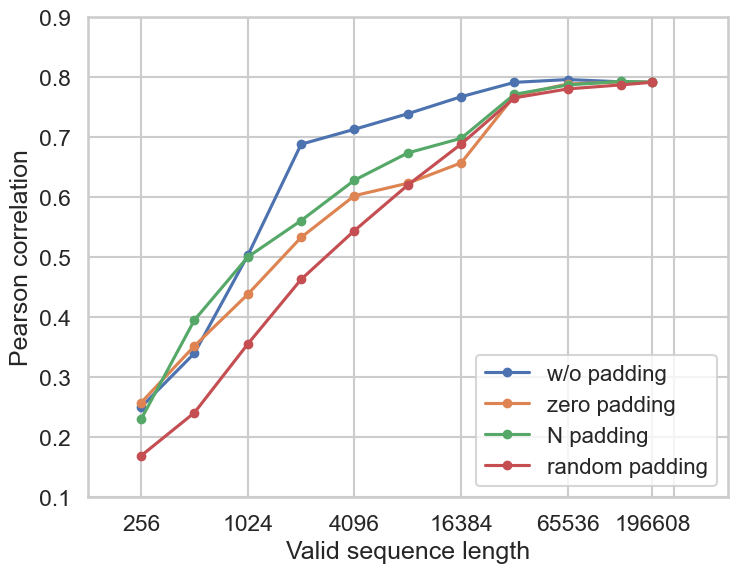

In [4]:
# enformer

plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)

length_list = np.array([256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 196608])
target = np.load('data/enformer_targets_test_center_2.npy')
# print(target.shape)


pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='w/o padding')


pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_zero.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='zero padding')


pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_N.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='N padding')



pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    # print(pred.shape)
    pred_list.append(pred)
pred_list = np.stack(pred_list)
pred_list = pred_list.mean(1)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding')





plt.xlim(7, 19)
plt.ylim(0.1, 0.9)
plt.xticks([8, 10, 12, 14, 16, 16+np.log2(3), 18], labels=[256, 1024, 4096, 16384, 65536, 196608, ''])
plt.yticks(0.1 * np.arange(1, 10))
plt.xlabel('Valid sequence length')
plt.ylabel('Pearson correlation')
plt.legend(fontsize=16, loc='lower right')
plt.savefig('figures/correlation_between_3_padding_methods.png', dpi=400)
plt.savefig('figures/correlation_between_3_padding_methods.pdf', dpi=400)
plt.show()

[0.14831763 0.2190007  0.32825761 0.42501433 0.50697009 0.67599033 0.73477368 0.73628863 0.73806766 0.73806766]
[0.14961445 0.21899548 0.32970724 0.42660532 0.50855883 0.67742352 0.73501291 0.73659921 0.73806766 0.73806766]


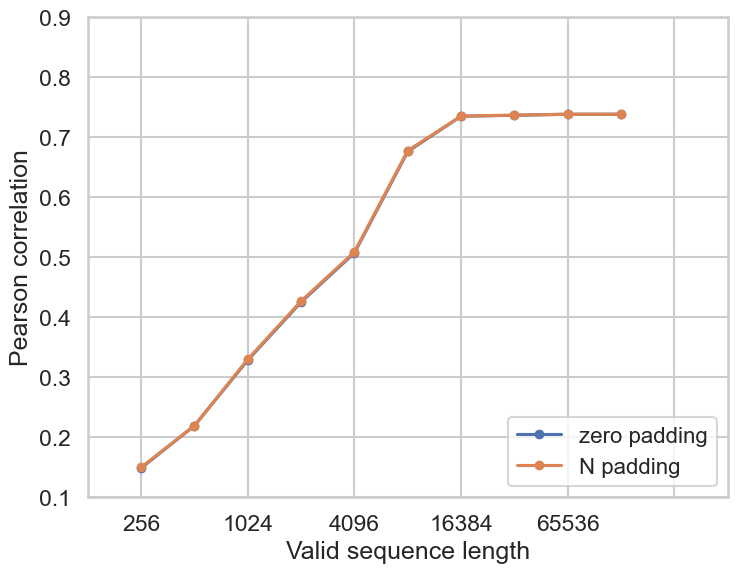

In [9]:
# basenji2

plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)

length_list = np.array([256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072])
target = np.load('data/enformer_targets_test_center_2.npy')
# print(target.shape)


# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}.npy')
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='w/o padding')


pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}_pad_131072_zero.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
print(corr)
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='zero padding')


pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}_pad_131072_N.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
print(corr)
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='N padding')



# pred_list = []
# for cropped_length in length_list:
#     pred = np.load(f'outputs/Basenji2_pred_crop_{cropped_length}_pad_131072_random_5_times.npy')
#     # print(pred.shape)
#     pred_list.append(pred)
# pred_list = np.stack(pred_list)
# pred_list = pred_list.mean(1)
# corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
# corr = corr[-1, :-1]
# plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding')





plt.xlim(7, 19)
plt.ylim(0.1, 0.9)
plt.xticks([8, 10, 12, 14, 16, 18], labels=[256, 1024, 4096, 16384, 65536, ''])
plt.yticks(0.1 * np.arange(1, 10))
plt.xlabel('Valid sequence length')
plt.ylabel('Pearson correlation')
plt.legend(fontsize=16, loc='lower right')
plt.savefig('figures/correlation_between_3_padding_methods.png', dpi=400)
plt.savefig('figures/correlation_between_3_padding_methods.pdf', dpi=400)
plt.show()

(11, 5, 1937, 2, 5313)
(11, 5, 1937, 2, 5313)


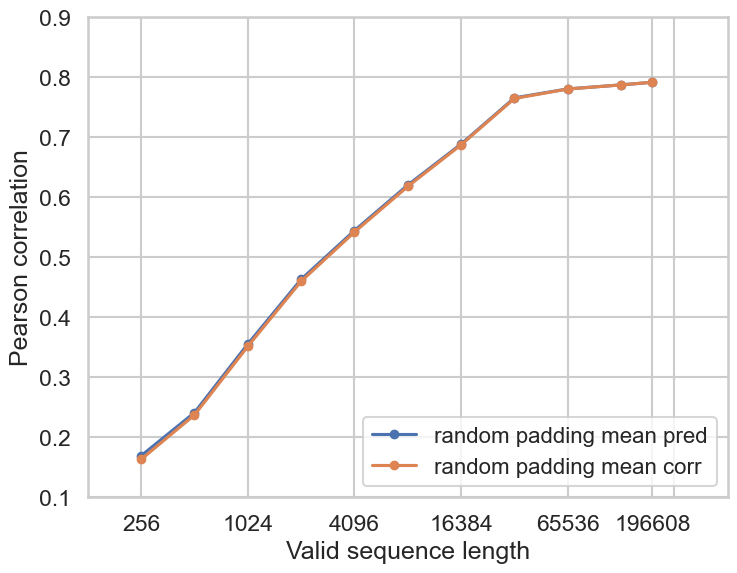

In [4]:
plt.figure(figsize=(8, 6), dpi=100)
plt.subplots_adjust(left=0.13, bottom=0.13, right=0.93, top=0.93)




pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
pred_list = pred_list.mean(1)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1]
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding mean pred')



pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
# (11, 5, 1937, 2, 5313)
pred_list = pred_list.reshape(-1, 1937, 2, 5313)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))
corr = corr[-1, :-1].reshape(-1, 5).mean(1)
plt.plot(np.log2(length_list), corr, marker="o", markersize=6, label='random padding mean corr')




plt.xlim(7, 19)
plt.ylim(0.1, 0.9)
plt.xticks([8, 10, 12, 14, 16, 16+np.log2(3), 18], labels=[256, 1024, 4096, 16384, 65536, 196608, ''])
plt.yticks(0.1 * np.arange(1, 10))
plt.xlabel('Valid sequence length')
plt.ylabel('Pearson correlation')
plt.legend(fontsize=16, loc='lower right')
plt.savefig('figures/correlation_random_mean.png', dpi=400)
plt.show()

In [5]:
pred_list = []
for cropped_length in length_list:
    pred = np.load(f'outputs/Enformer_pred_crop_{cropped_length}_pad_196608_random_5_times.npy')
    pred_list.append(pred)
pred_list = np.stack(pred_list)
print(pred_list.shape)
# (11, 5, 1937, 2, 5313)
pred_list = pred_list.reshape(-1, 1937, 2, 5313)
corr = np.corrcoef(pred_list.reshape(pred_list.shape[0], -1), target.reshape(-1))

print(corr)

(11, 5, 1937, 2, 5313)
[[1.         0.91465899 0.91662061 ... 0.16742964 0.16742964 0.16327258]
 [0.91465899 1.         0.91243314 ... 0.16608902 0.16608902 0.16096631]
 [0.91662061 0.91243314 1.         ... 0.16871918 0.16871918 0.16371049]
 ...
 [0.16742964 0.16608902 0.16871918 ... 1.         1.         0.79138096]
 [0.16742964 0.16608902 0.16871918 ... 1.         1.         0.79138096]
 [0.16327258 0.16096631 0.16371049 ... 0.79138096 0.79138096 1.        ]]
